In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import OPTICS
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns

In [2]:
# Load the dataset
data_path = '../data/events.csv'  # Update the path to your file
data = pd.read_csv(data_path)

In [3]:
# Filter data to include only rows with valid shot_place
shots_data = data.dropna(subset=['shot_place'])

In [4]:
# Reduce the dataset size for quicker execution (e.g., 1000 samples)
shots_data = shots_data.sample(n=1000, random_state=42)
print("Reduced dataset shape:", shots_data.shape)

Reduced dataset shape: (1000, 22)


In [5]:
# Define features to include
categorical_columns = ['side', 'bodypart', 'assist_method', 'situation', 'fast_break', 'event_team', 'opponent']
numerical_columns = ['time', 'shot_outcome', 'location', 'is_goal']

In [6]:
# Handle missing values in numerical columns
shots_data[numerical_columns] = shots_data[numerical_columns].fillna(shots_data[numerical_columns].mean())
print("Data after filling missing values:")
print(shots_data.head())

Data after filling missing values:
          id_odsp    id_event  sort_order  time  \
763533  MHZSkeoD/  MHZSkeoD88          88    84   
143031  CSIVz9Rt/  CSIVz9Rt60          60    77   
901230  AT8BU3Vt/  AT8BU3Vt97          97    87   
127033  dfsta8kI/  dfsta8kI38          38    39   
659151  Qa1FLFwr/  Qa1FLFwr20          20    29   

                                                     text  event_type  \
763533  Goal!  Nantes 2, Bordeaux 1. Cheick DiabatA© (...           1   
143031  Goal!  FC Nurnberg 1, Bayer Leverkusen 3. Andr...           1   
901230  Attempt blocked. Alexandre Mendy (Guingamp) ri...           1   
127033  Attempt blocked. Alejandro Alfaro (Mallorca) r...           1   
659151  Attempt missed. Ola Toivonen (Rennes) right fo...           1   

        event_type2  side        event_team          opponent  ... player_in  \
763533         12.0     2          Bordeaux            Nantes  ...       NaN   
143031         12.0     2  Bayer Leverkusen          Nurnbe

In [7]:
# Balance the dataset using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(shots_data, shots_data['shot_place'])
shots_data = pd.DataFrame(X_balanced, columns=shots_data.columns)
print("Balanced dataset shape:", shots_data.shape)

Balanced dataset shape: (2873, 22)


In [8]:
# Preprocessing: One-hot encode categorical and scale numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
    ],
    remainder='drop'
)

In [9]:
# Apply preprocessing
processed_data = preprocessor.fit_transform(shots_data).toarray()
print("Processed data shape:", processed_data.shape)

Processed data shape: (2873, 290)


In [10]:
# Ensure at least 100 features by padding with zero columns if needed
if processed_data.shape[1] < 100:
    padding = np.zeros((processed_data.shape[0], 100 - processed_data.shape[1]))
    processed_data = np.hstack([processed_data, padding])
    print("Padded data to 100 features.")

In [11]:
# Perform OPTICS clustering
optics_model = OPTICS(min_samples=5, metric='euclidean', cluster_method='xi')
print("Fitting OPTICS model...")
optics_model.fit(processed_data)
print("OPTICS clustering complete.")

Fitting OPTICS model...
OPTICS clustering complete.


c:\Users\stoic\miniconda3\envs\llms_env\lib\site-packages\sklearn\cluster\_optics.py:1083: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [12]:
# Extract clustering labels
labels = optics_model.labels_
shots_data['cluster'] = labels
print("Cluster labels:", labels[:10])


Cluster labels: [  0  19  -1  -1  -1  -1 106  -1  -1 117]


In [13]:
# Evaluate clustering
unique_labels = set(labels)
print(f"Clusters found: {unique_labels}")
if len(unique_labels) > 1:
    silhouette = silhouette_score(processed_data, labels, metric='euclidean')
    davies_bouldin = davies_bouldin_score(processed_data, labels)
    calinski_harabasz = calinski_harabasz_score(processed_data, labels)
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz:.4f}")
else:
    print("Clustering metrics cannot be computed with fewer than 2 clusters.")

Clusters found: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, -1}
Silhouette Score: 0.3087
Davies-Bouldin Index: 1.1595
Calinski-Harabasz Score: 18.1424


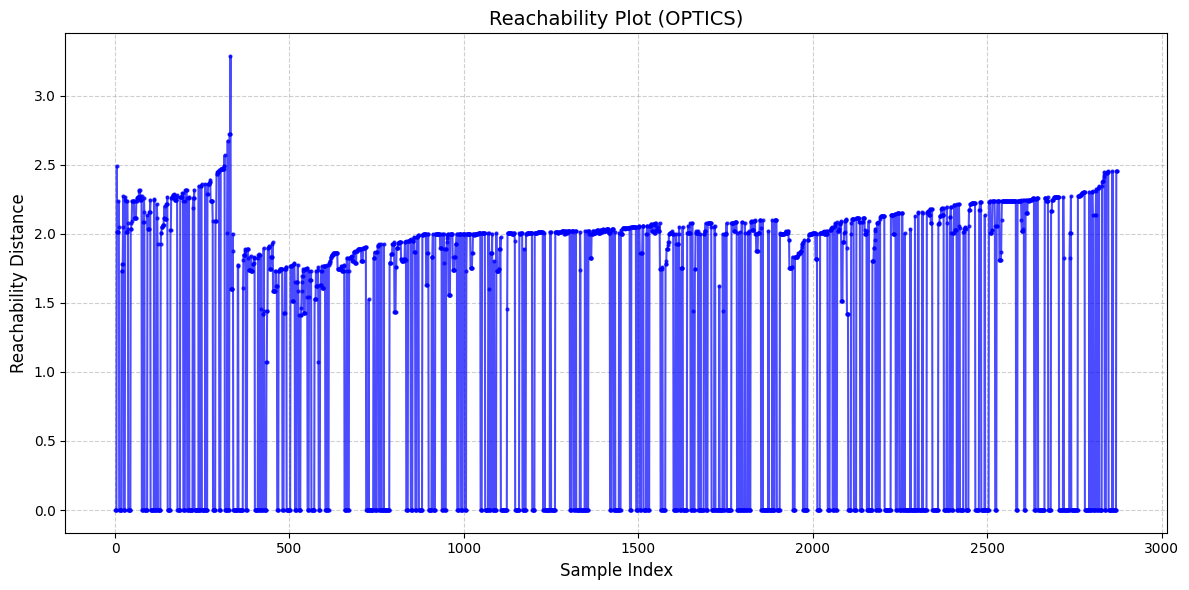

In [14]:
# Visualize the reachability plot
plt.figure(figsize=(12, 6))
space = range(processed_data.shape[0])
reachability = optics_model.reachability_[optics_model.ordering_]
plt.plot(space, reachability, marker='o', markersize=2, color='blue', alpha=0.7)
plt.title('Reachability Plot (OPTICS)', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Reachability Distance', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [15]:
# Analyze the clustering results
unique_labels = set(labels)
print(f"Clusters found: {unique_labels}")

Clusters found: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, -1}


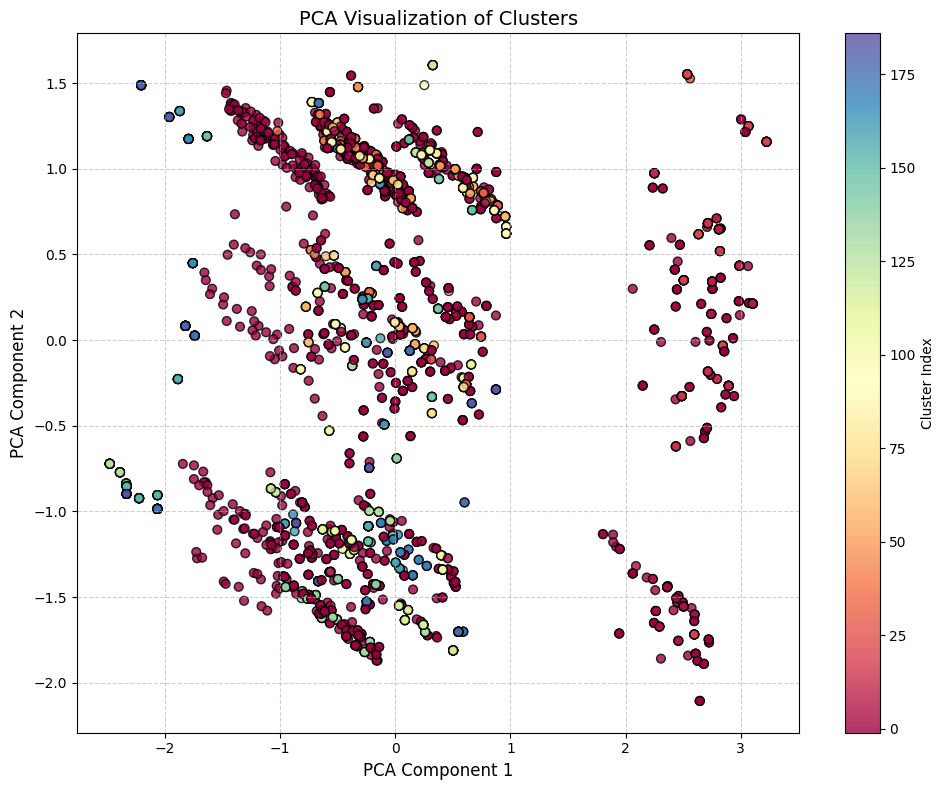

In [16]:
# Visualize clusters using PCA with improved color palette and colorbar
pca = PCA(n_components=2)
pca_data = pca.fit_transform(processed_data)
num_clusters = len(unique_labels)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_data[:, 0], 
    pca_data[:, 1], 
    c=labels, 
    cmap='Spectral', 
    s=40, 
    edgecolor='k', 
    alpha=0.8
)
plt.title('PCA Visualization of Clusters', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.colorbar(scatter, label="Cluster Index")  # Add a colorbar with the label
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [17]:
# Analyze shot_place proportions within each cluster
cluster_proportions = shots_data.groupby('cluster')['shot_place'].value_counts(normalize=True).unstack(fill_value=0)
print("Proportion of shot_place in each cluster:")
print(cluster_proportions)

Proportion of shot_place in each cluster:
shot_place      1.0       2.0       3.0       4.0       5.0       6.0   7.0   \
cluster                                                                        
-1          0.008614  0.171496  0.098669  0.109632  0.121378  0.105717   0.0   
 0          0.000000  0.000000  1.000000  0.000000  0.000000  0.000000   0.0   
 1          0.000000  0.000000  0.000000  1.000000  0.000000  0.000000   0.0   
 2          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0   
 3          0.000000  0.000000  0.000000  1.000000  0.000000  0.000000   0.0   
...              ...       ...       ...       ...       ...       ...   ...   
 182        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0   
 183        1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0   
 184        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0   
 185        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   1.0  

In [18]:
# Assign shot_place label to each cluster based on majority vote
cluster_to_label = cluster_proportions.idxmax(axis=1)
print("Cluster-to-shot_place mapping:")
print(cluster_to_label)

Cluster-to-shot_place mapping:
cluster
-1       2.0
 0       3.0
 1       4.0
 2      12.0
 3       4.0
        ... 
 182    10.0
 183     1.0
 184    10.0
 185     7.0
 186     1.0
Length: 188, dtype: float64


In [19]:
# Map the predicted labels back to the dataset
shots_data['predicted_shot_place'] = shots_data['cluster'].map(cluster_to_label)

In [20]:
# Compute accuracy
valid_rows = shots_data['predicted_shot_place'].notna()
accuracy = accuracy_score(shots_data.loc[valid_rows, 'shot_place'], shots_data.loc[valid_rows, 'predicted_shot_place'])
print(f"Accuracy of clustering-based shot_place prediction: {accuracy:.4f}")

Accuracy of clustering-based shot_place prediction: 0.5816


In [21]:
# Save the final dataset
shots_data.to_csv('clustered_shots_with_predictions.csv', index=False)
print("Clustered data with predictions saved to 'clustered_shots_with_predictions.csv'.")

Clustered data with predictions saved to 'clustered_shots_with_predictions.csv'.


In [22]:
# For curiosity, check the distribution of shot_place after balancing
print("Shot place distribution after balancing:")
print(shots_data['shot_place'].value_counts())

Shot place distribution after balancing:
shot_place
3.0     221
2.0     221
9.0     221
10.0    221
8.0     221
5.0     221
4.0     221
6.0     221
1.0     221
12.0    221
7.0     221
13.0    221
11.0    221
Name: count, dtype: int64


In [23]:
# Number of entries in each cluster
print("Number of entries in each cluster:")
print(shots_data['cluster'].value_counts())

Number of entries in each cluster:
cluster
-1      1277
 177      22
 178      20
 174      20
 79       20
        ... 
 36        5
 172       5
 42        5
 88        5
 3         5
Name: count, Length: 188, dtype: int64
